In [28]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

**1. Моделирование аттрактора**


---


В данном случае, используем аттрактор Лоренца в качестве приближенной модели климата, где описывается хаотическое поведение климатических процессов.



*   *lorenz_climate* - функция, которая описывает дифференциальные уравнения с параметрами $σ, β, ρ$
*   *solve_ivp* - функция, решающая систему ОДУ, и генерируя временной ряд состояния системы (𝑥, 𝑦, 𝑧)

Описание системы Лоренца:

$\frac{dx}{dt} = σ(y-x)$

$\frac{dy}{dt} = x(ρ-z) - y$

$\frac{dz}{dt} = xy - βz$


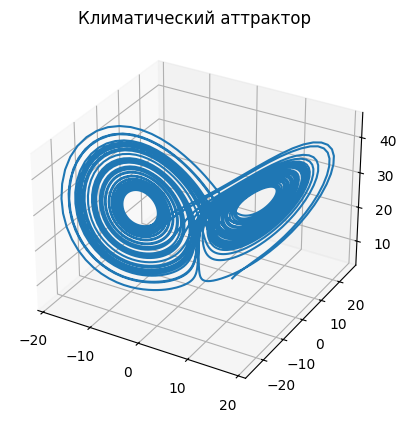

In [29]:
def lorenz_climate(t, state, sigma=10, beta=8/3, rho=28):
    x, y, z = state
    dx = sigma * (y - x)
    dy = x * (rho - z) - y
    dz = x * y - beta * z
    return [dx, dy, dz]

T = 50     # Общее время интегрирования
dt = 0.01   # Шаг интегрирования
t_span = (0, T)
t_eval = np.arange(0, T, dt)
initial_state = [5.0, 5.0, 5.0]     # Начальное состояние системы
sol = solve_ivp(lorenz_climate, t_span, initial_state, t_eval=t_eval)   # Решение ОДУ

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(sol.y[0], sol.y[1], sol.y[2])
ax.set_title("Климатический аттрактор")
plt.show()

**2. Расчёт экспоненты Ляпунова**


---


Данный показатель указывает на то, насколько быстро расходятся траектории системы при малых возмущениях.

Система решается дважды:
1. С исходным состоянием
2. С возмущенным состоянием

Затем, необходимо найти разницу в расхождениях траекторий относительно времени. Если показатель положительный, то система хаотична и долгосрочный прогноз является сложновычислимым.


*   *system*         - функция системы;
*  *initial_state*  - начальное состояние системы;
*   *dt*             - шаг интегрирования;
*   *T*             - общее время интегрирования для расчёта экспоненты;
*   *renorm_interval* - интервал времени, после которого происходит перенормировка*;
*   *delta0*         - заданное начальное возмущение;

$\lambda_{сред} = \frac{\sum \log(d/\delta_0)}{N \cdot \text{renorm_interval}}$ - средняя экспонента Ляпунова, где $N$ - кол-во интервалов;

In [34]:
def lyapunov_exponent(system, initial_state, dt, T, renorm_interval=1.0, delta0=1e-5):
    num_steps = int(T / dt)
    steps_per_interval = int(renorm_interval / dt)
    current_state = np.array(initial_state)
    # Начальное возмущение
    perturbed_state = current_state + np.array([delta0, 0, 0])
    sum_log = 0.0
    N = 0
    t_current = 0.0

    while t_current < T:
        t_span_interval = (t_current, t_current + renorm_interval)
        t_eval_interval = np.arange(t_current, t_current + renorm_interval, dt)

        sol1 = solve_ivp(system, t_span_interval, current_state, t_eval=t_eval_interval)
        sol2 = solve_ivp(system, t_span_interval, perturbed_state, t_eval=t_eval_interval)

        # Вычисляем расстояние между траекториями в конце интервала
        d = np.linalg.norm(sol2.y[:, -1] - sol1.y[:, -1])

        sum_log += np.log(d / delta0)

        # Перенормировка: направление разности сохраняем, величину сбрасываем до delta0
        direction = (sol2.y[:, -1] - sol1.y[:, -1]) / d
        current_state = sol1.y[:, -1]
        perturbed_state = current_state + delta0 * direction

        t_current += renorm_interval
        N += 1

    # Средняя экспонента Ляпунова = сумма логарифмов / общее время
    lambda_avg = sum_log / (N * renorm_interval)
    return lambda_avg

lambda_val = lyapunov_exponent(lorenz_climate, initial_state, dt=0.01, T=100, renorm_interval=1.0, delta0=1e-5)
print("Экспонента Ляпунова:", lambda_val)

Экспонента Ляпунова: 0.8821995873368742


*В данном случае, интегрирование делится на короткие интервалы и в конце каждого из них сбрасывается разность между траекториями до исходного значения δ0 (сохраняя при этом направление, в котором эта разность росла). Таким образом, перенормировка позволяет измерить рост расхождения в нужных пределах.

**3. LSTM - модель**



---

*   В качестве данных используются точки $(x, y, z)$ из решения *solve_ivp()* в 1-ом пункте;
*   Нормализация данных при помощи *MinMaxScaler()*;

*   Разделение данных (80% - тренировка, 20% - тест);
*   Создание LSTM - модели с 2-мя слоями (по 64 нейрона), и выходным слоем (3 нейрона для $x, y, z$);





In [31]:
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(sol.y.T)

X, y_seq = [], []
seq_length = 100
for i in range(len(data_scaled) - seq_length):
    X.append(data_scaled[i:i+seq_length])
    y_seq.append(data_scaled[i+seq_length])
X, y_seq = np.array(X), np.array(y_seq)

split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y_seq[:split], y_seq[split:]

In [32]:
model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(seq_length, 3)),
    LSTM(64),
    Dense(3)
])
model.compile(optimizer='adam', loss='mse')
model.fit(X_train, y_train, epochs=5, batch_size=16,
          validation_data=(X_test, y_test), shuffle = False)


predicted = model.predict(X_test)
predicted_rescaled = scaler.inverse_transform(predicted)

Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


245/245 ━━━━━━━━━━━━━━━━━━━━ 21s 72ms/step - loss: 0.0235 - val_loss: 0.0047
Epoch 2/5
245/245 ━━━━━━━━━━━━━━━━━━━━ 21s 74ms/step - loss: 0.0021 - val_loss: 0.0034
Epoch 3/5
245/245 ━━━━━━━━━━━━━━━━━━━━ 20s 70ms/step - loss: 6.8217e-04 - val_loss: 0.0021
Epoch 4/5
245/245 ━━━━━━━━━━━━━━━━━━━━ 20s 71ms/step - loss: 6.4302e-04 - val_loss: 0.0033
Epoch 5/5
245/245 ━━━━━━━━━━━━━━━━━━━━ 21s 74ms/step - loss: 5.2401e-04 - val_loss: 0.0027
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step


**4. Визуализация работы LSTM**



---

Представлены графики по трём координатам $x, y, z$

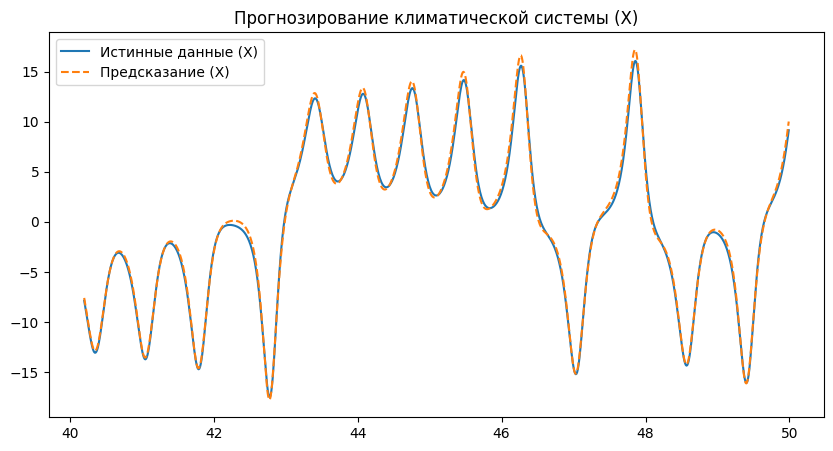

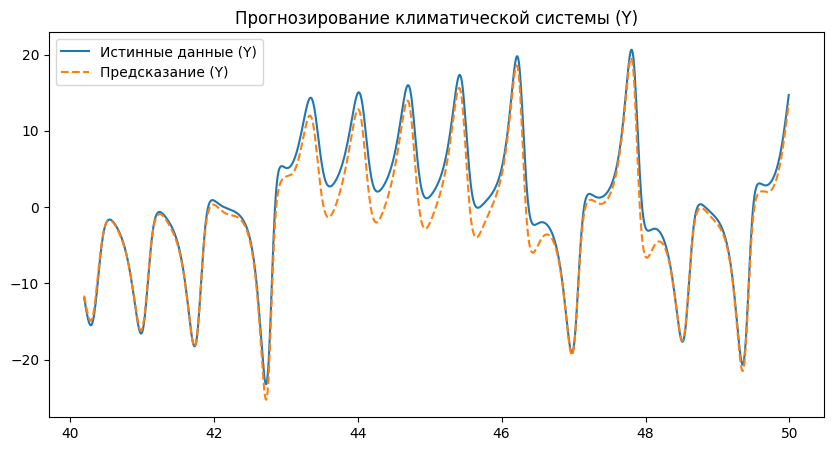

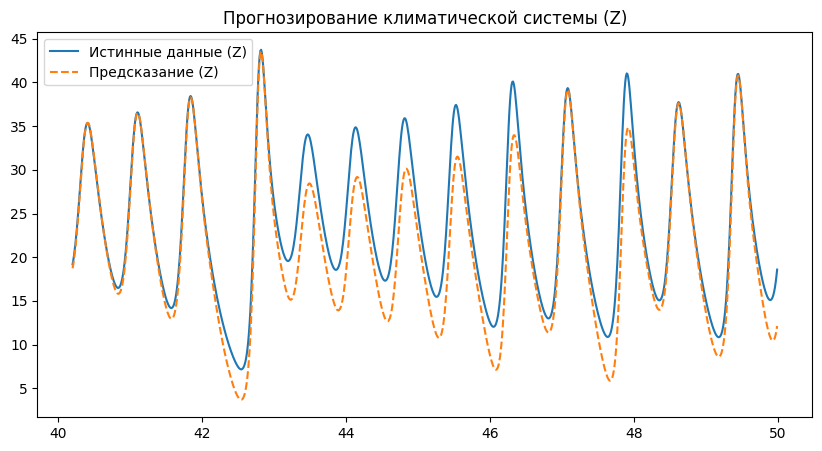

In [33]:
time_test = sol.t[seq_length + split : seq_length + split + len(X_test)]

plt.figure(figsize=(10, 5))
plt.plot(time_test, sol.y[0, seq_length + split : seq_length + split + len(X_test)], label='Истинные данные (X)')
plt.plot(time_test, predicted_rescaled[:, 0], label='Предсказание (X)', linestyle='dashed')
plt.title("Прогнозирование климатической системы (X)")
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(time_test, sol.y[1, seq_length + split : seq_length + split + len(X_test)], label='Истинные данные (Y)')
plt.plot(time_test, predicted_rescaled[:, 1], label='Предсказание (Y)', linestyle='dashed')
plt.title("Прогнозирование климатической системы (Y)")
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(time_test, sol.y[2, seq_length + split : seq_length + split + len(X_test)], label='Истинные данные (Z)')
plt.plot(time_test, predicted_rescaled[:, 2], label='Предсказание (Z)', linestyle='dashed')
plt.title("Прогнозирование климатической системы (Z)")
plt.legend()
plt.show()

На графиках видно, что на небольших интервалах времени (слева на графике) истинные данные практически совпадают с предсказанными, что означает высокую точность LSTM в краткосрочном прогнозе. Однако, с продвижением времени расхождения становятся заметнее (особенно на графиках по Y и Z). Это свидетельствует о том, что небольшая ошибка в начальных условиях со временем накапливается, из-за чего прогноз становится менее точным.

Несмотря на это, система остается в правильном диапазоне значений, благодаря тому, что модель захватила основные характеристики динамики системы.



---



*   Благодаря численным методам была решена система Лоренца и построен аттрактор, который демонстрирует, что система не имеет периодического поведения.
*   Экспонента Ляпунова демонстрирует, насколько быстро расходятся близкие траектории системы, и что она чувствительна к начальному состоянию.
*   Данные, полученные из системы Лоренца, были использованы для обучения рекуррентной нейросети, которая предсказывает будущее состояние системы. Из-за хаотичной природы системы, прогнозы теряют точность на больших временых промежутках.



